### Prophet models for predicting the number of crimes in 77 Community Areas

In [ ]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import os
from tqdm import tqdm
import logging
from prophet.serialize import model_to_json

In [ ]:
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
# load data (77 community areas)
ts_fn = '/content/drive/MyDrive/Data/ts_data.zip'
zz = zipfile.ZipFile(ts_fn, 'r')
zz.extractall()
zz.close()

In [ ]:
dn = '/content/data'
fns = os.listdir(dn)
print(len(fns))
# fns

77


In [ ]:
# train models using the entire dataset
ca_list, model_list, forecast_list, t_res_list, scaler_list, future_list = ([] for xx in range(6))

for fn in tqdm(fns):
  df = pd.read_csv(os.path.join(dn, fn), index_col=0)
  t_res = fn.split('.')[0].split('_')[-1].upper()

  df1 = df.copy()
  spatial_region = df1['Community Area'].unique()[0]
  df1['ds'] = pd.to_datetime(df1['DateTime'])
  df1.rename(columns={'BullsGame':'bulls', 'CubsGame':'cubs', 'SoxGame':'sox', 'BearsGame':'bears', 
                    'C':'temp', 'm/s':'wind', 'PRCP':'rain', 'SNOW':'snow', 'Count':'y'}, inplace=True)


  holidays = pd.DataFrame({'holiday': 'holiday',
                          'ds': df1[df1['Holiday']==1]['ds'],
                          'lower_window': 0, 'upper_window': 1,})

  cols2drop = ['Date', 'HourGroup', 'DateTime', 'Year', 'Month', 'Day', 'Weekday', 'Holiday', 'Community Area']
  df1.drop(cols2drop, axis=1, inplace=True)

  assert df1.isna().sum().sum()==0

  cols2scale = ['temp', 'wind', 'rain', 'snow']
  scaler = StandardScaler().fit(df1[cols2scale])
  df1[cols2scale] = scaler.transform(df1[cols2scale])

  m = Prophet(holidays=holidays)
  extra_regressors = ['bulls', 'cubs', 'sox', 'bears', 'temp', 'wind', 'rain', 'snow']
  for regressor in extra_regressors:
    m.add_regressor(regressor)
  m.fit(df1)

  future = m.make_future_dataframe(periods=0, freq=t_res)
  tmp = df1.copy().drop('y', axis=1)
  future = future.merge(tmp, how='left', on='ds')

  assert len(future) == len(df1)

  forecast = m.predict(future)
  ca_list.append(spatial_region)
  model_fn = f'/content/drive/MyDrive/prophet_models/CA{spatial_region}_{t_res}.json'
  # print(model_fn)
  # with open(model_fn, 'w') as fout:
  #   fout.write(model_to_json(m)) 
  model_list.append(m)
  t_res_list.append(t_res)
  forecast_list.append(forecast)
  scaler_list.append(scaler)
  future_list.append(future)

df_results = pd.DataFrame({'ca':ca_list, 't_res':t_res_list, 'scaler':scaler_list, 'model':model_list, 'train_exog':future_list, 'forecast':forecast_list})

100%|██████████| 77/77 [27:00<00:00, 21.04s/it]


62


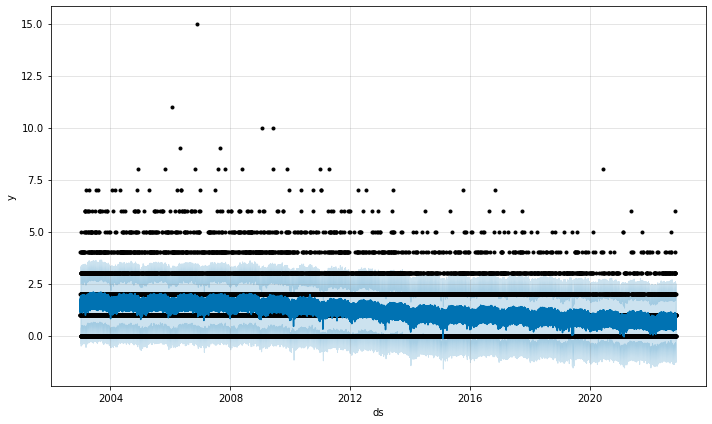

16


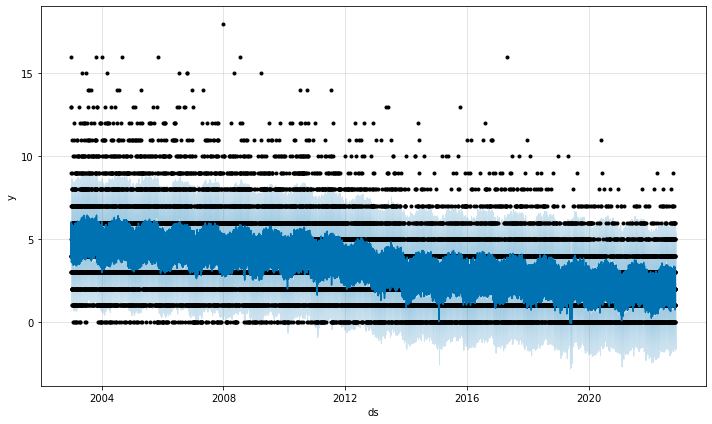

55


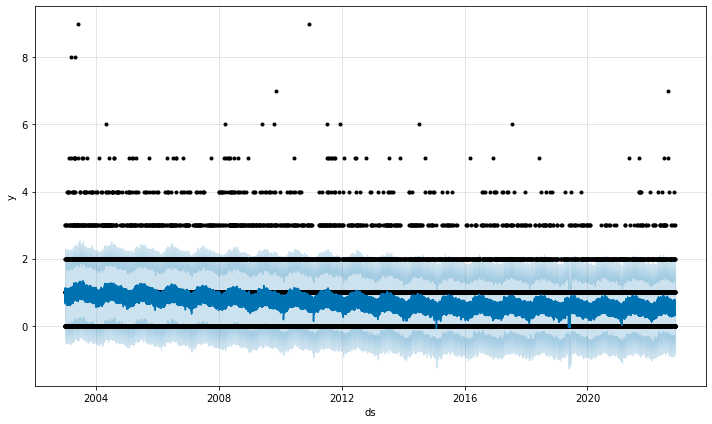

47


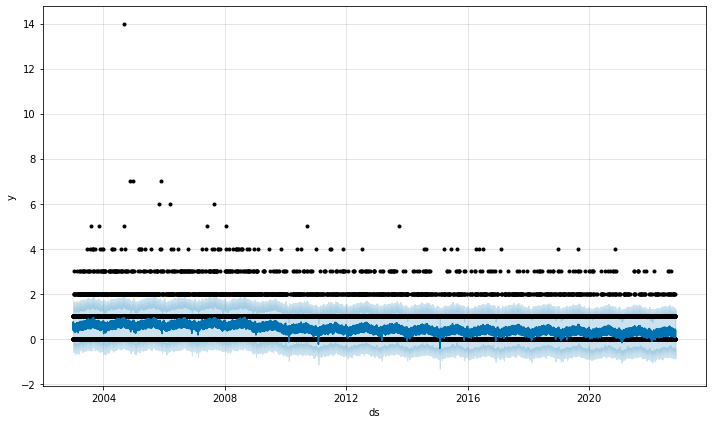

14


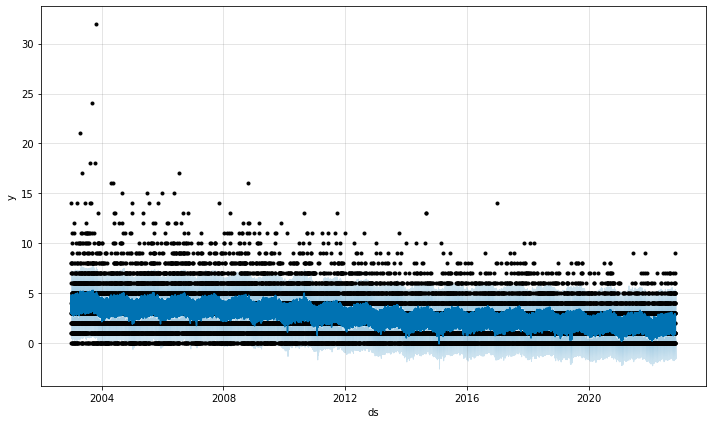

25


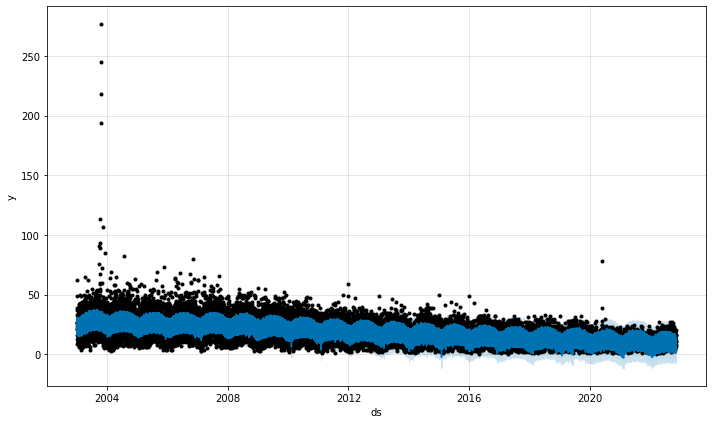

64


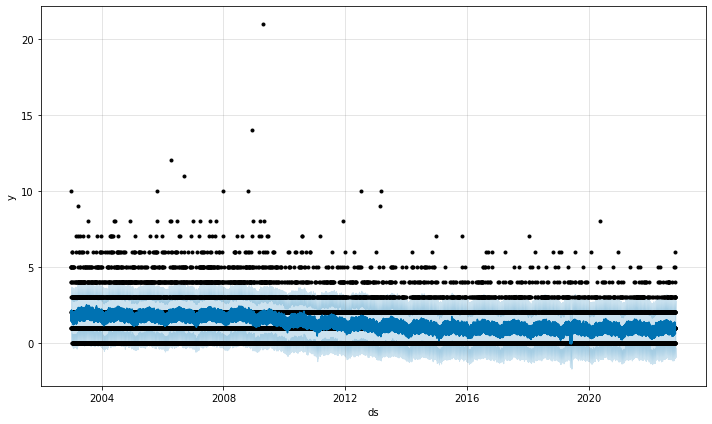

58


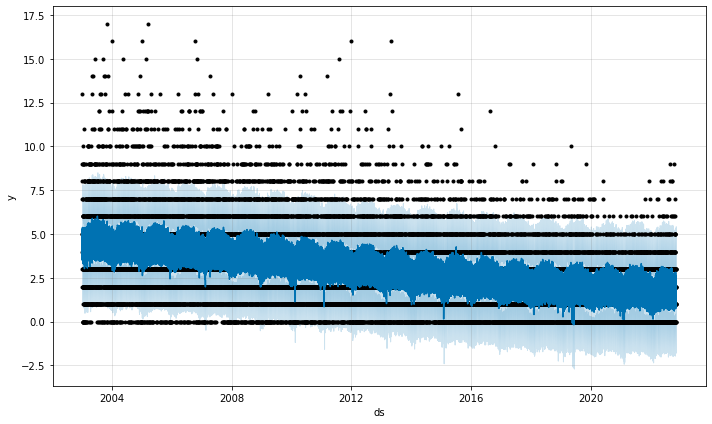

71


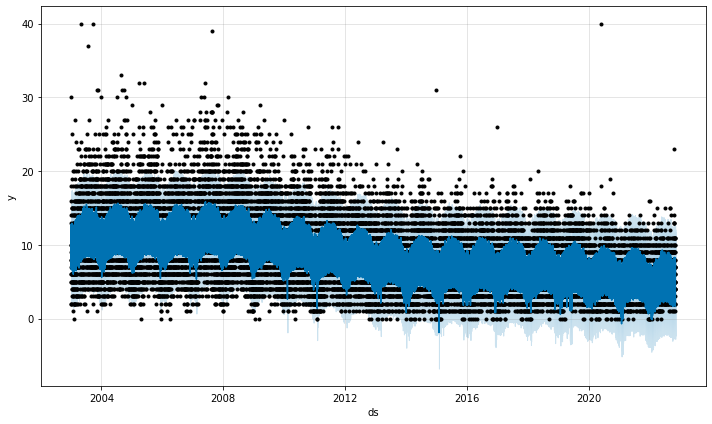

27


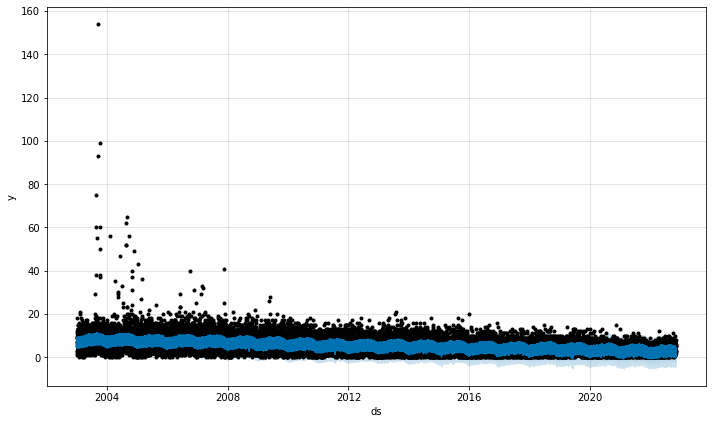

48


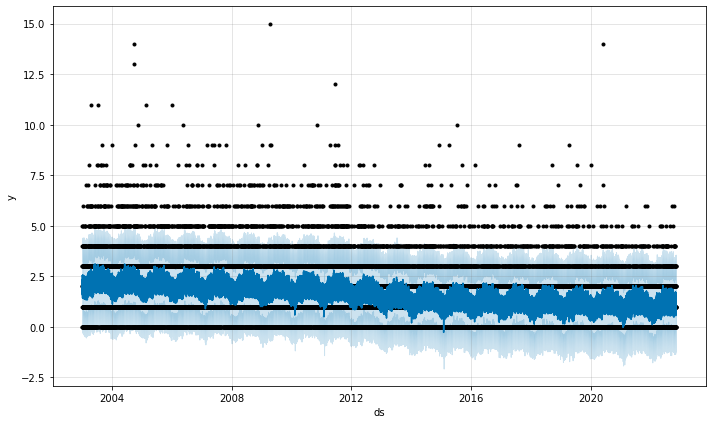

61


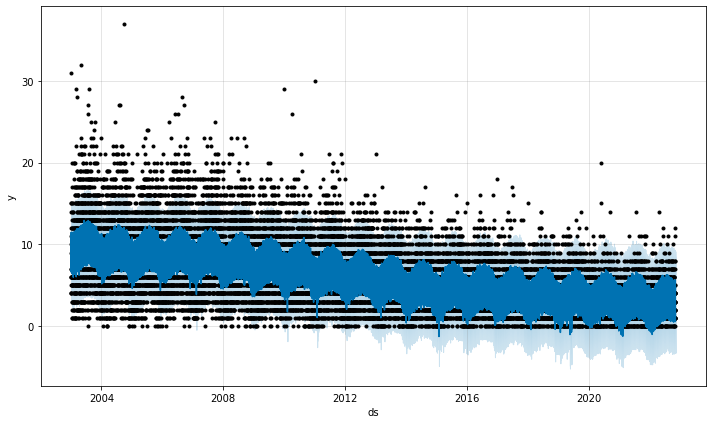

76


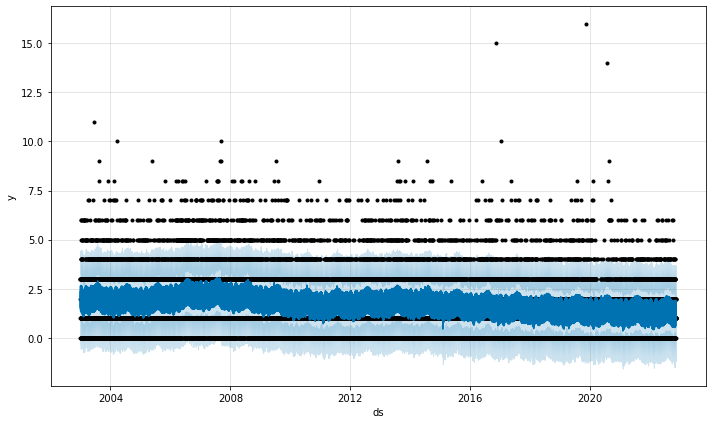

12


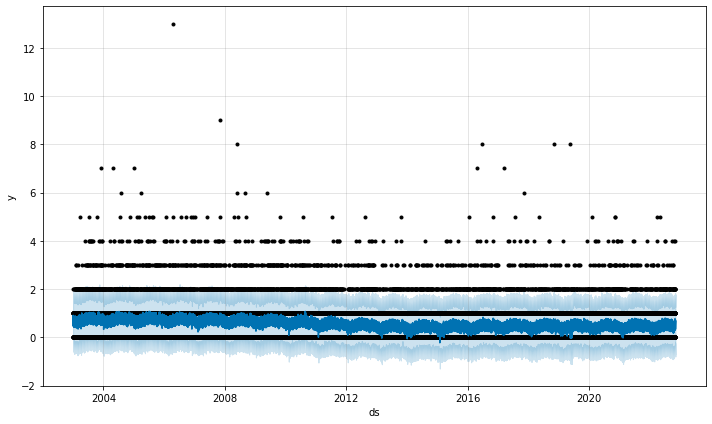

50


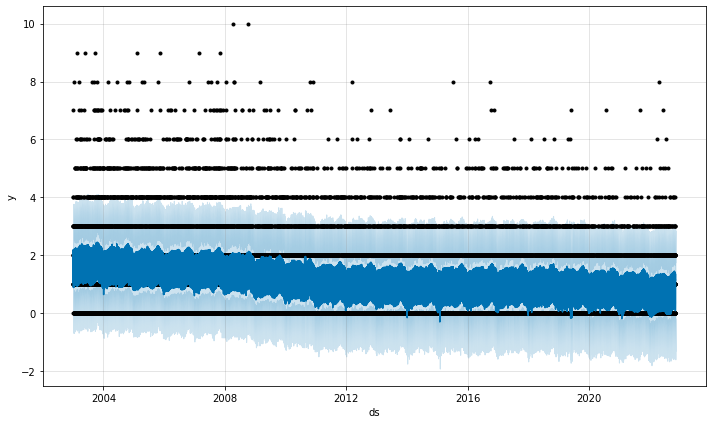

31


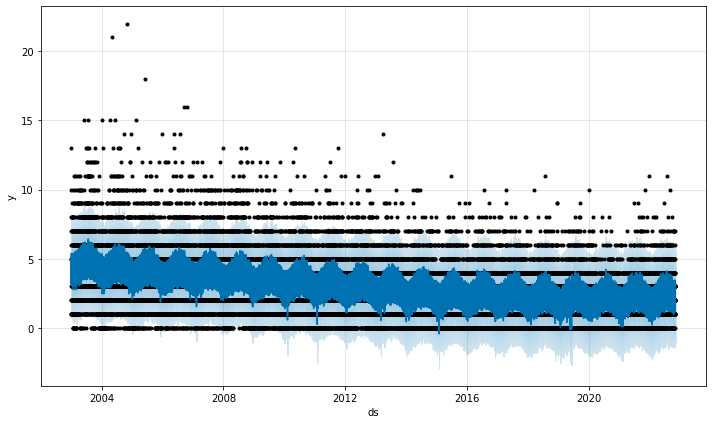

40


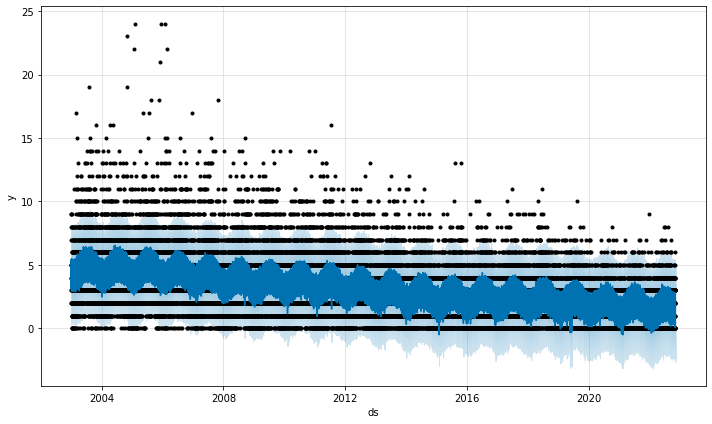

29


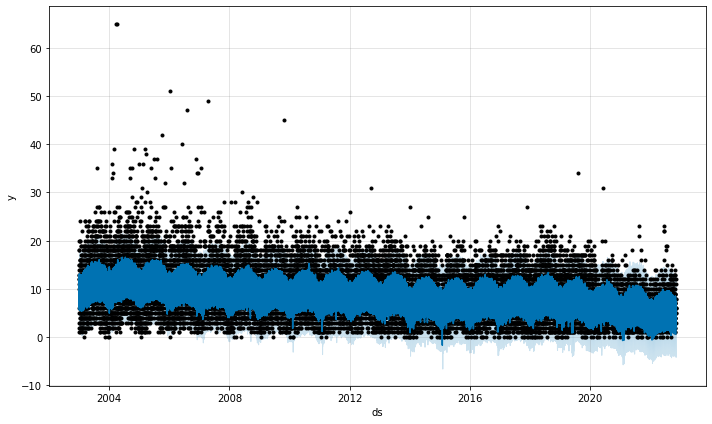

13


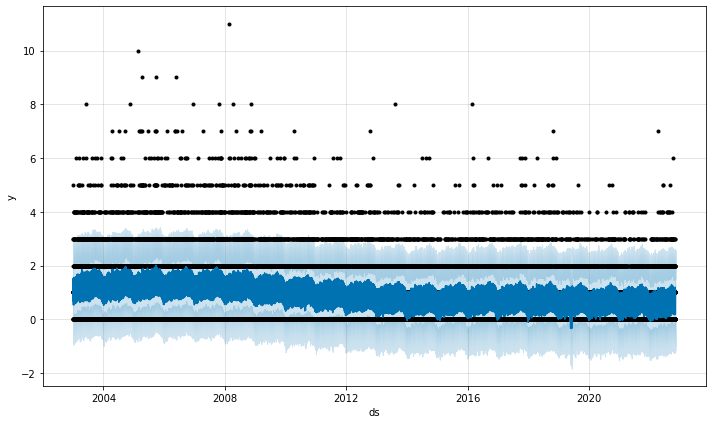

4


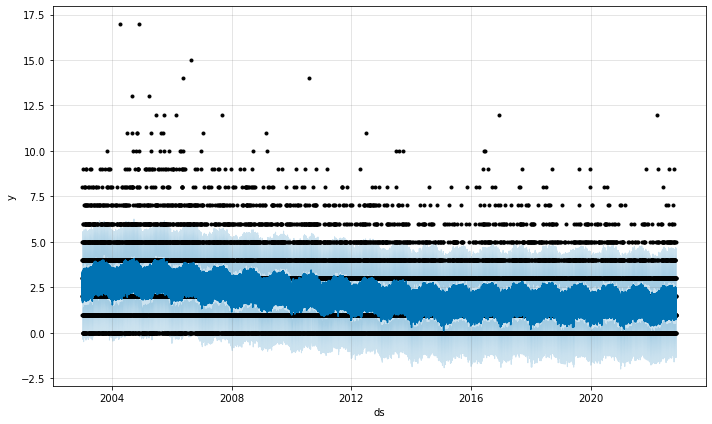

45


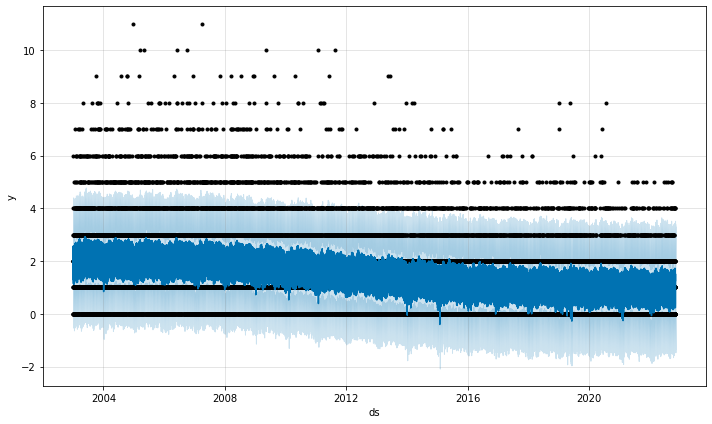

2


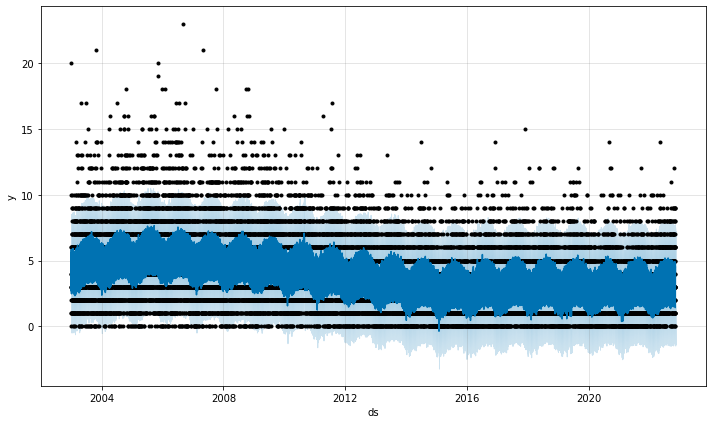

26


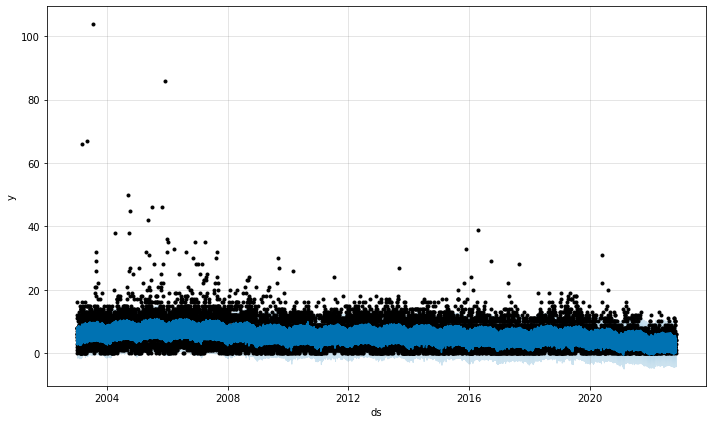

36


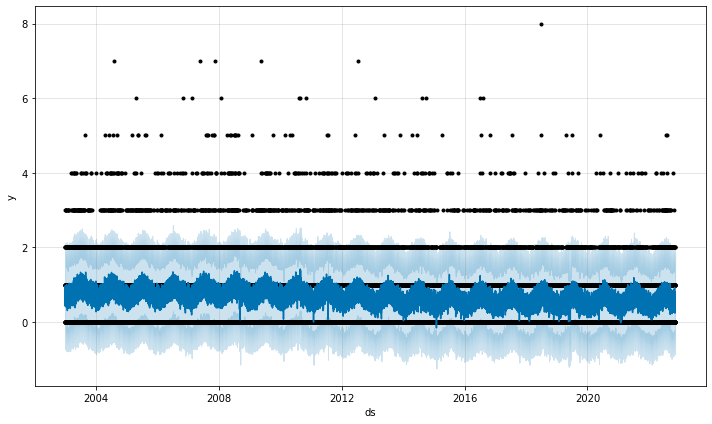

77


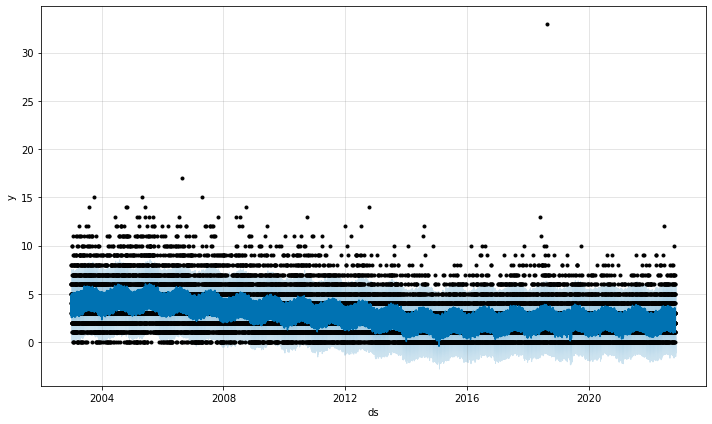

68


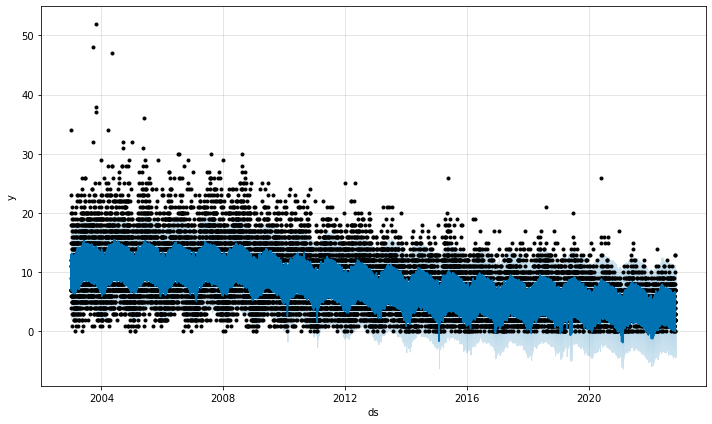

38


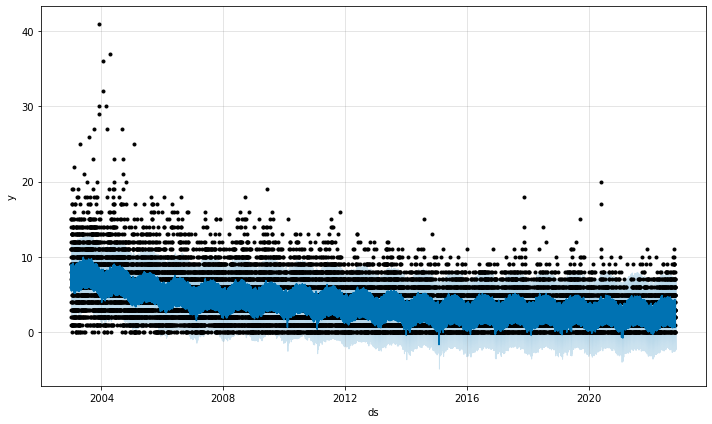

30


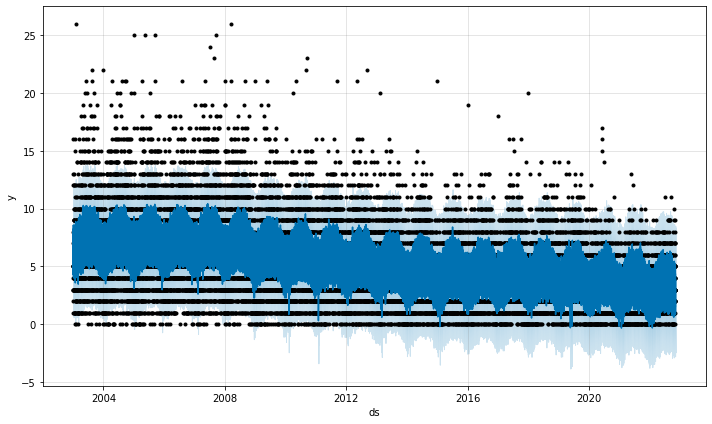

37


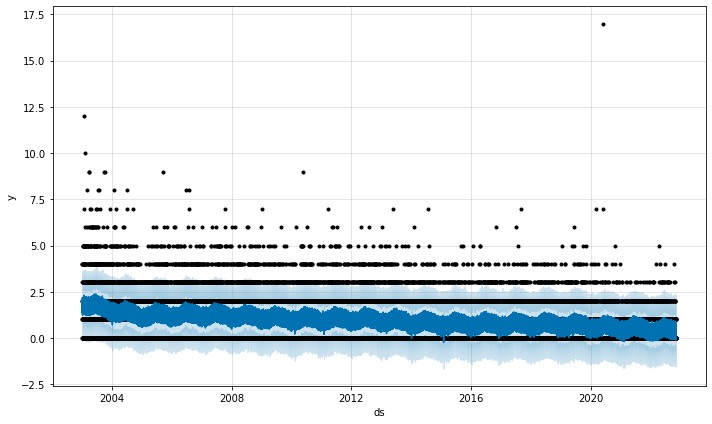

49


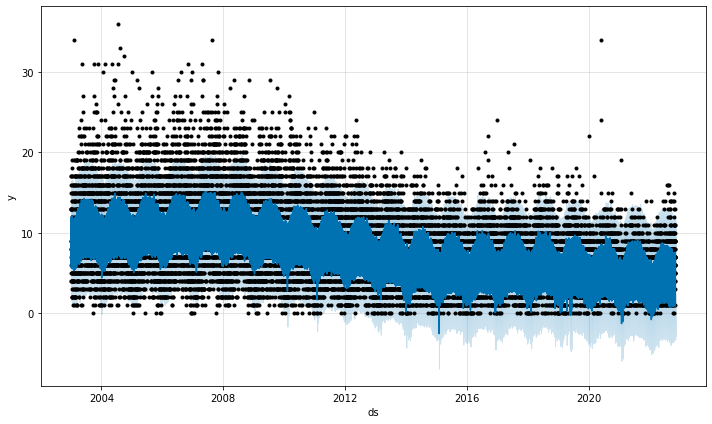

74


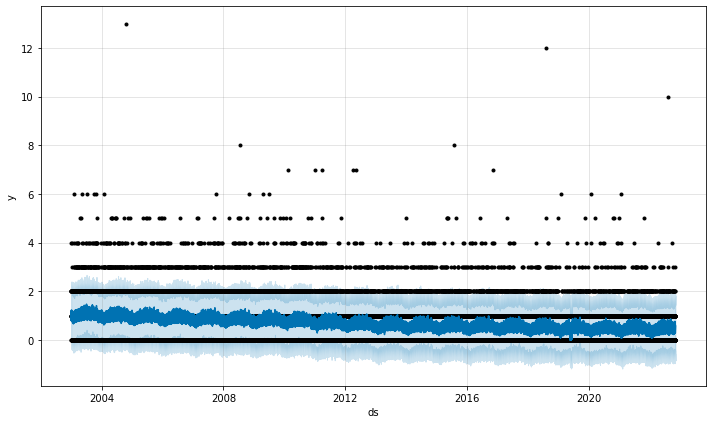

17


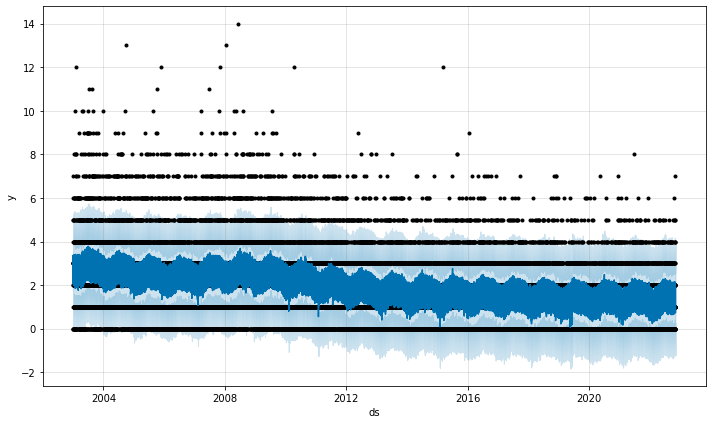

5


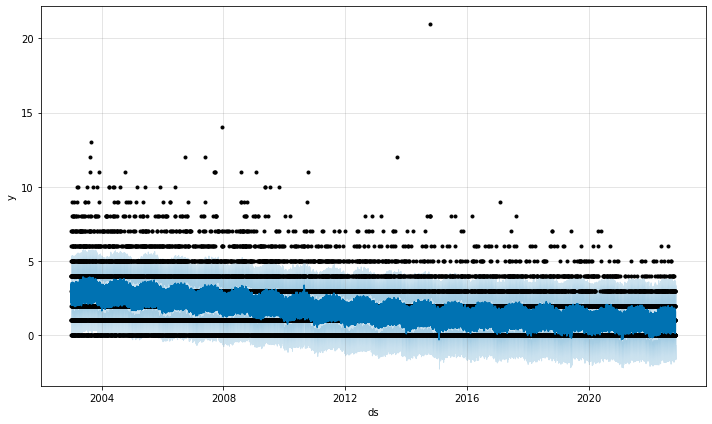

51


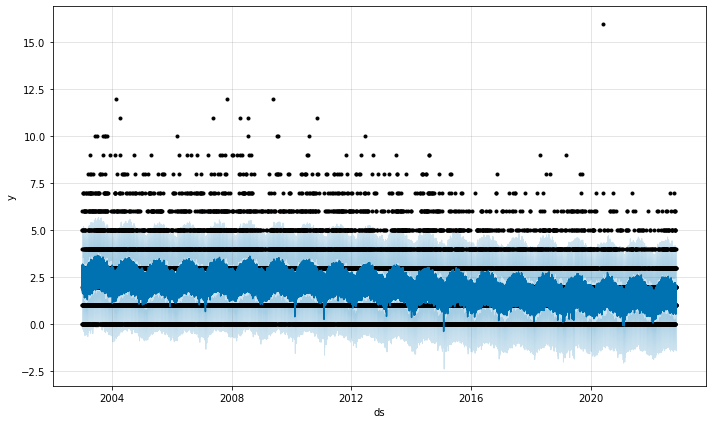

11


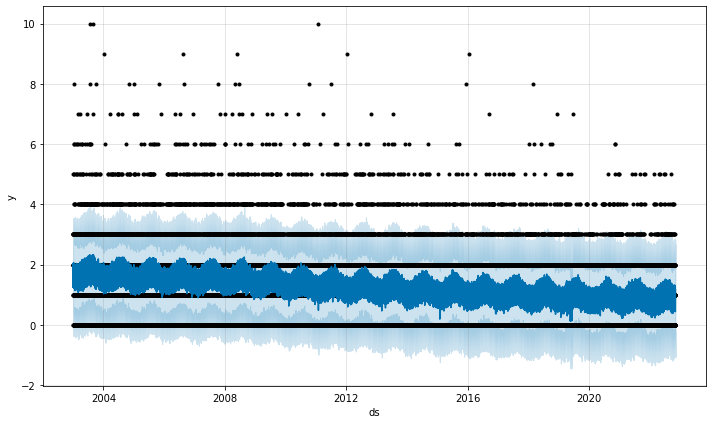

8


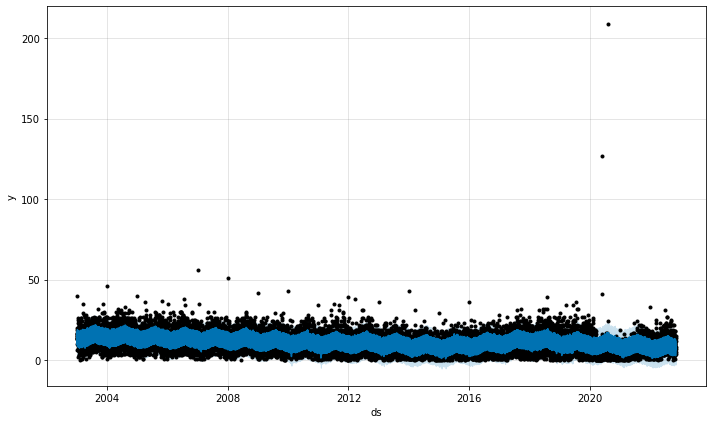

54


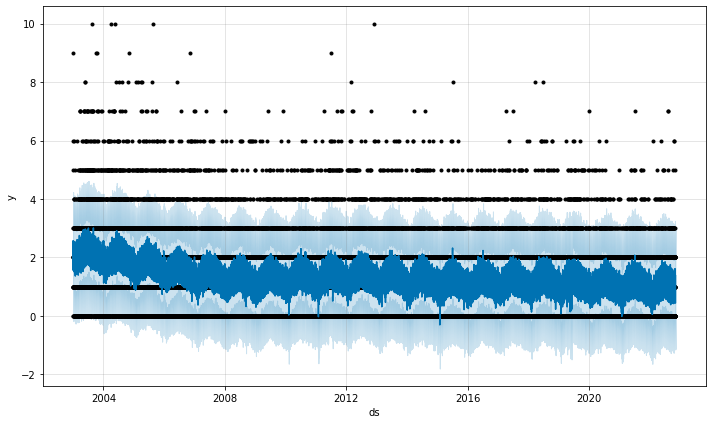

73


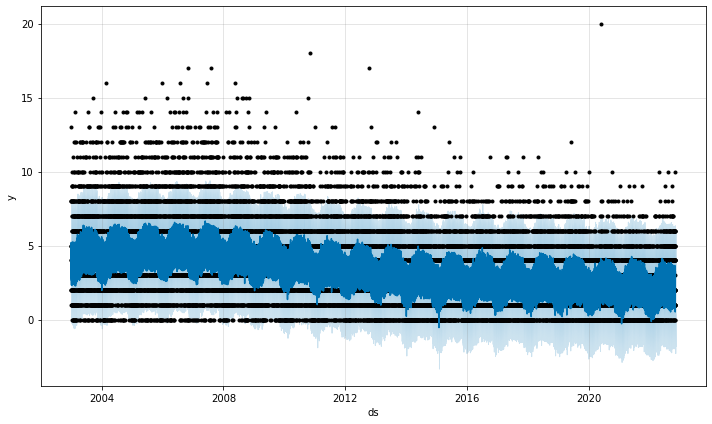

70


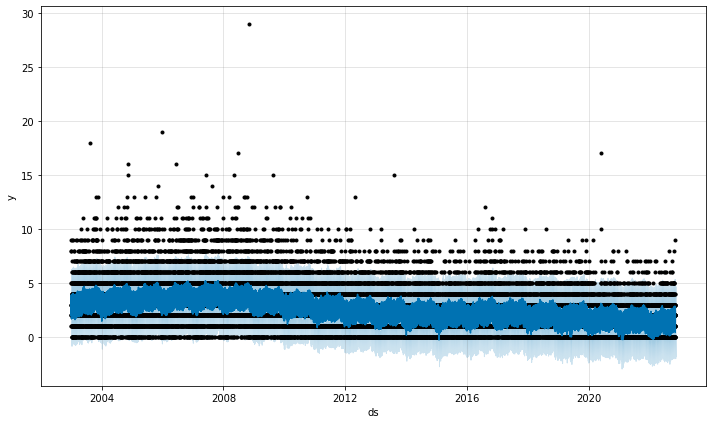

63


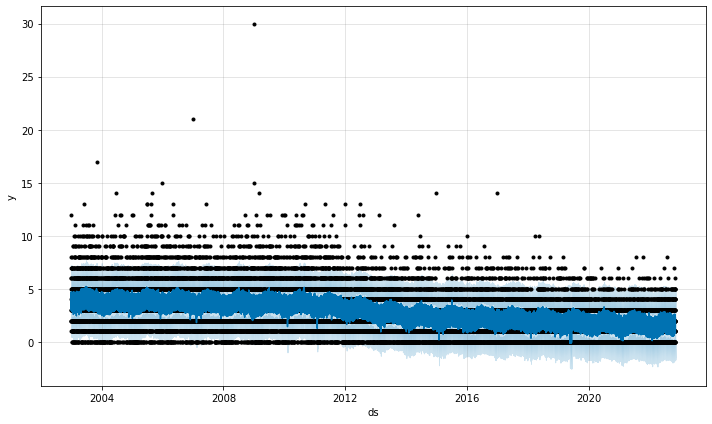

7


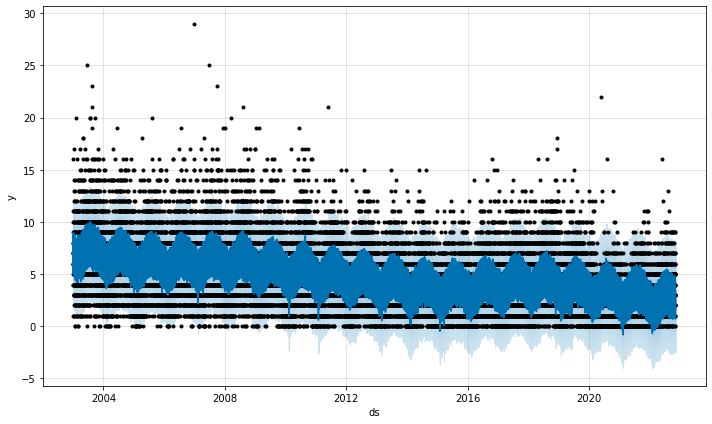

57


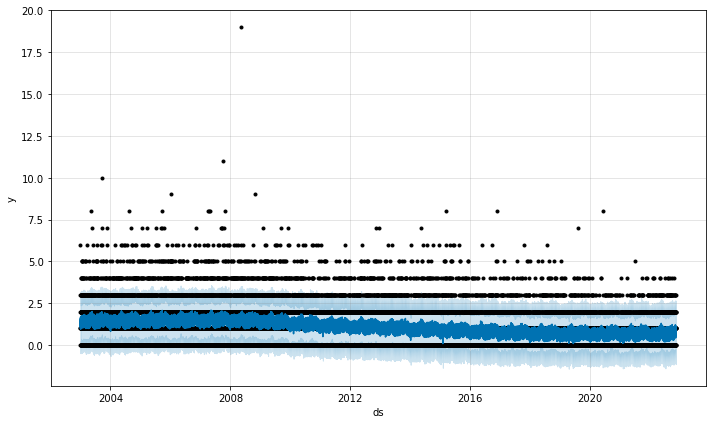

75


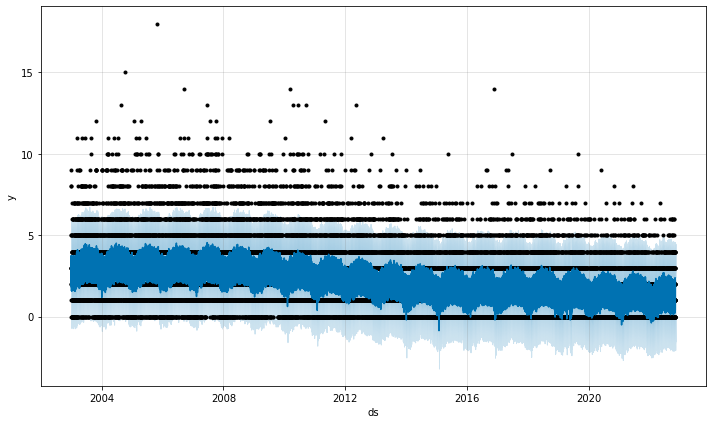

34


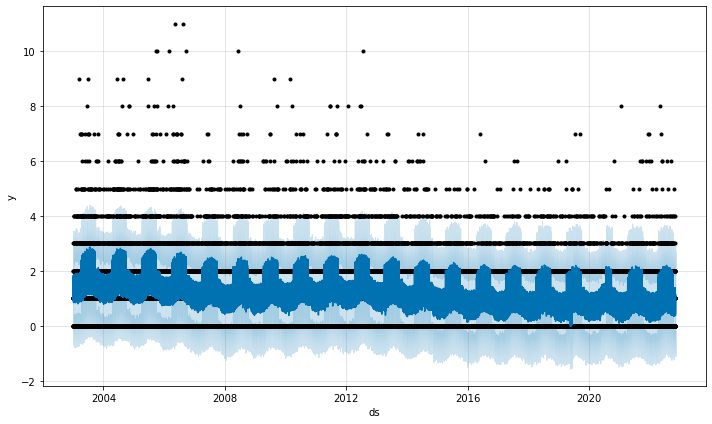

20


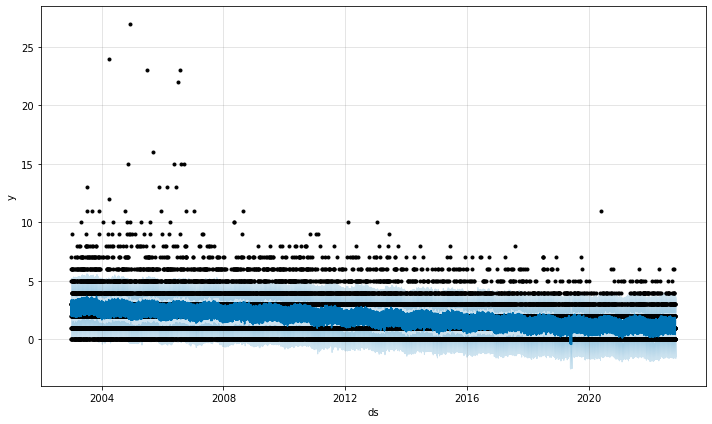

59


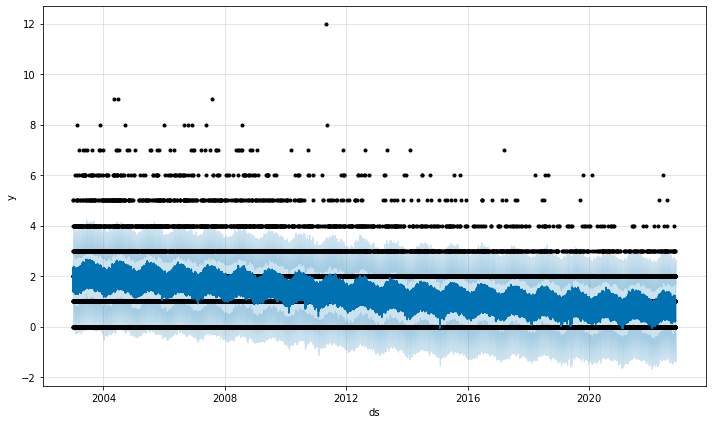

43


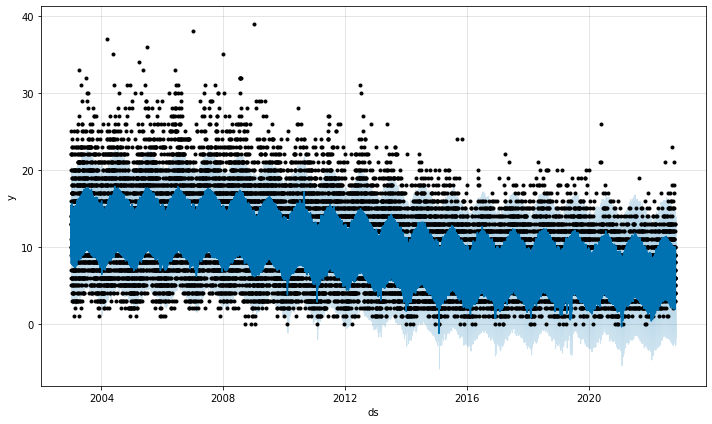

35


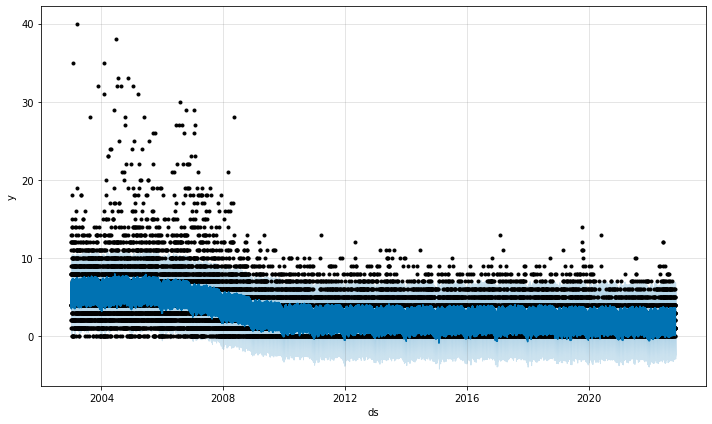

22


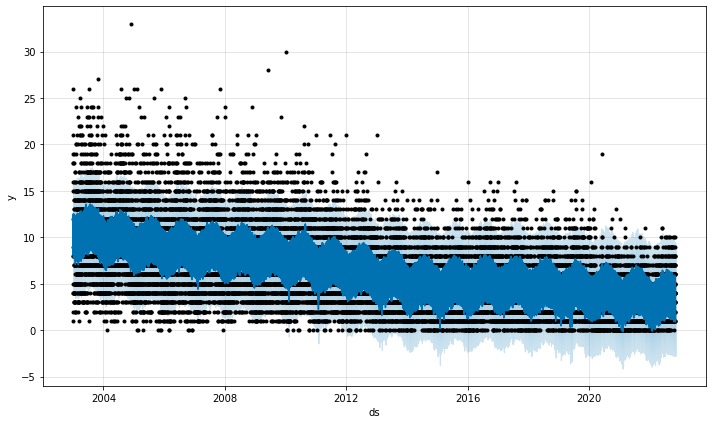

42


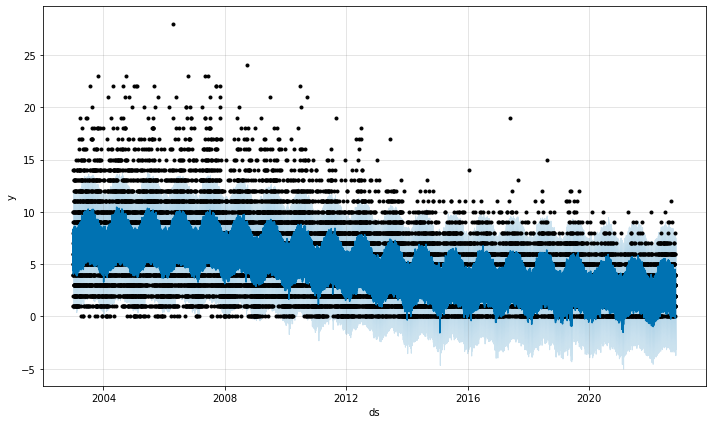

52


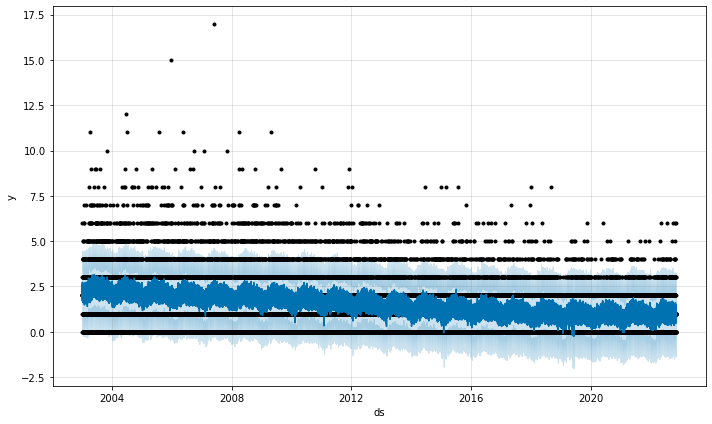

3


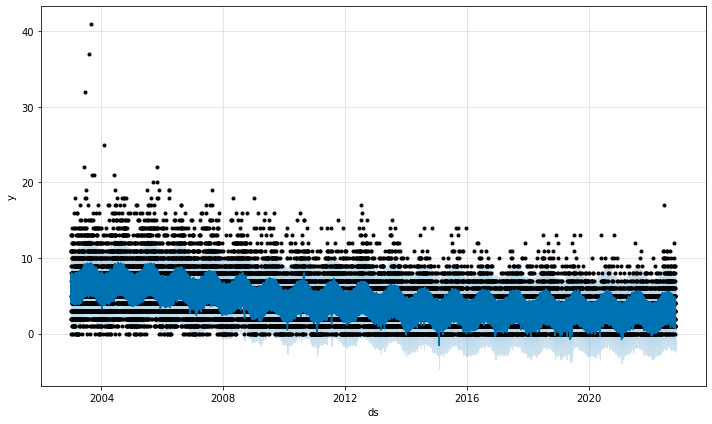

21


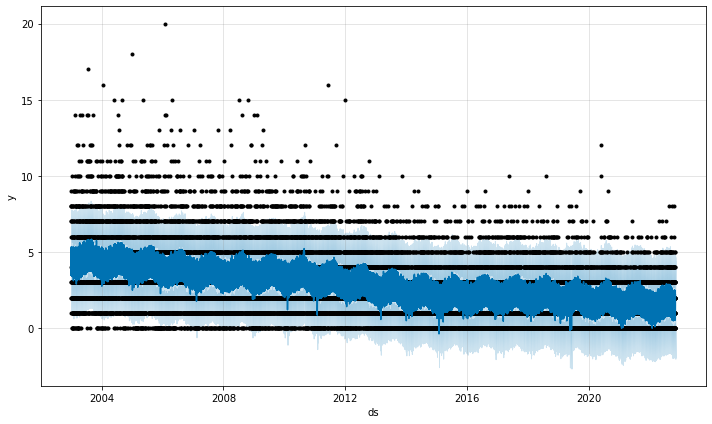

53


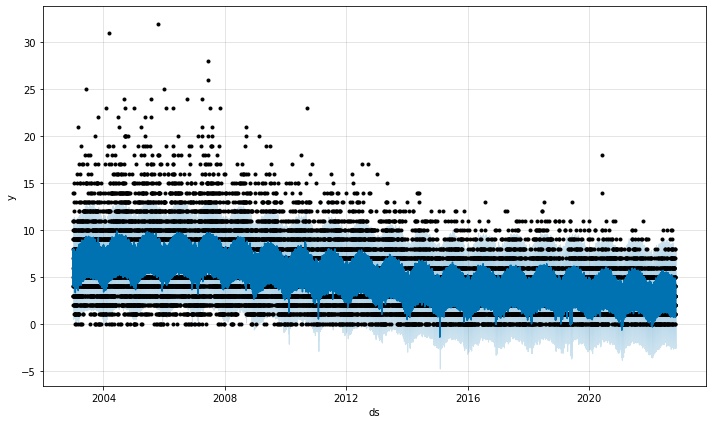

41


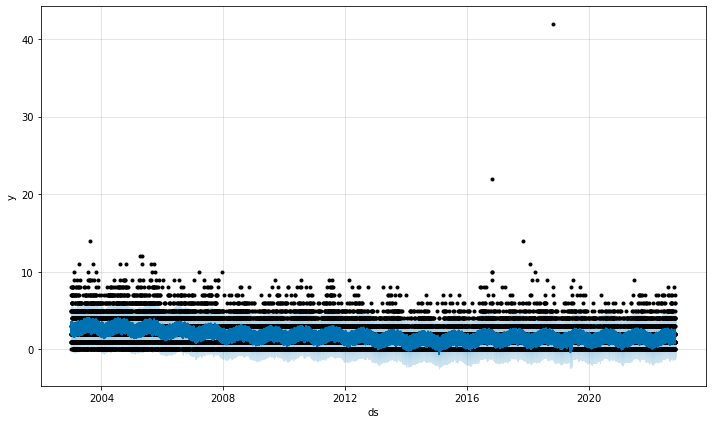

18


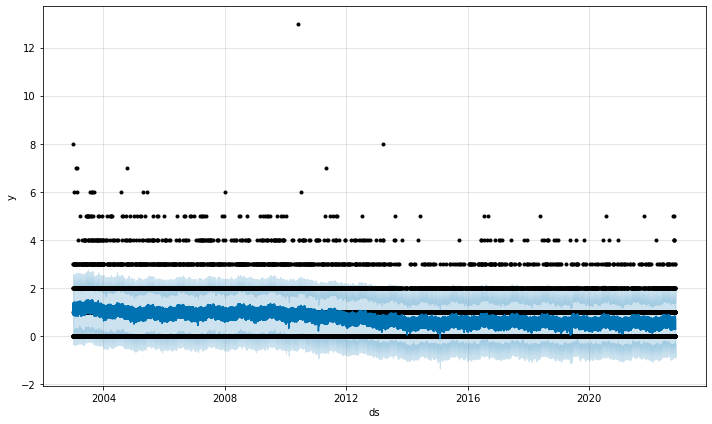

69


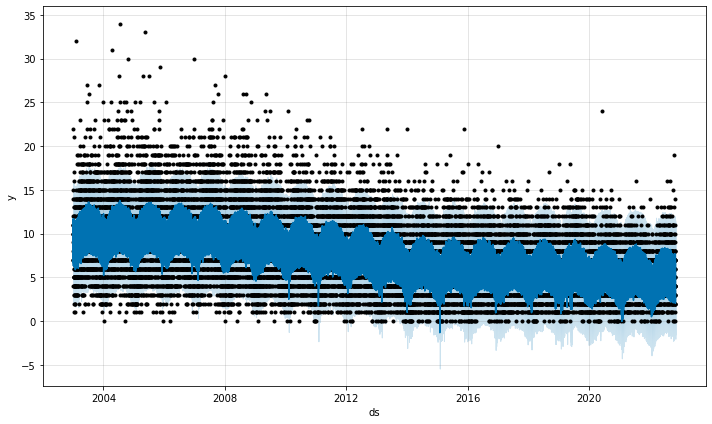

10


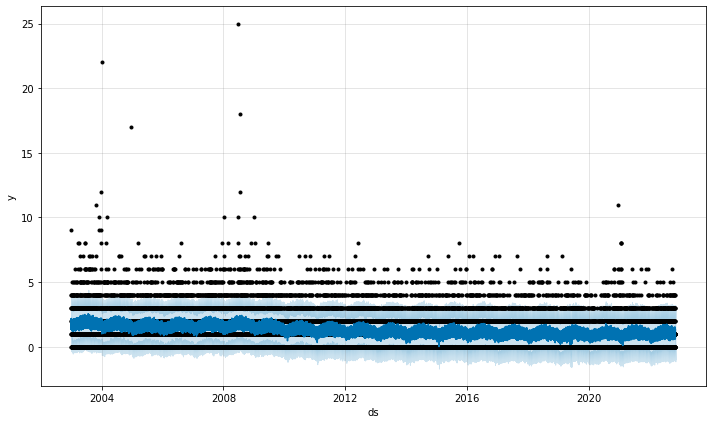

33


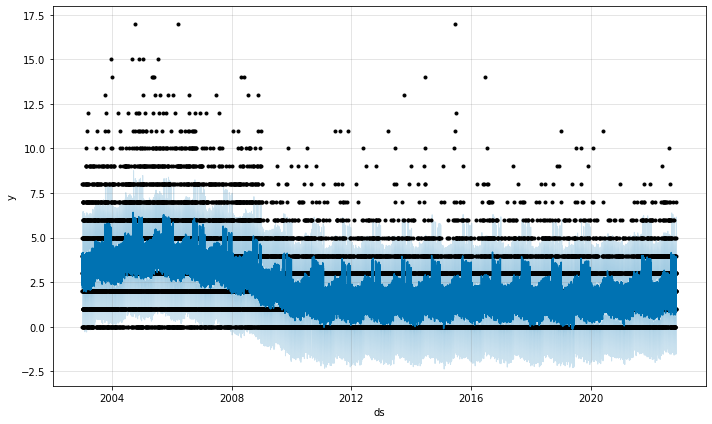

1


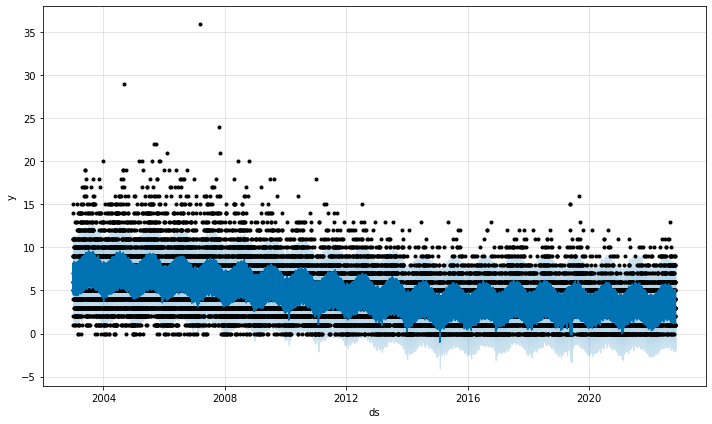

67


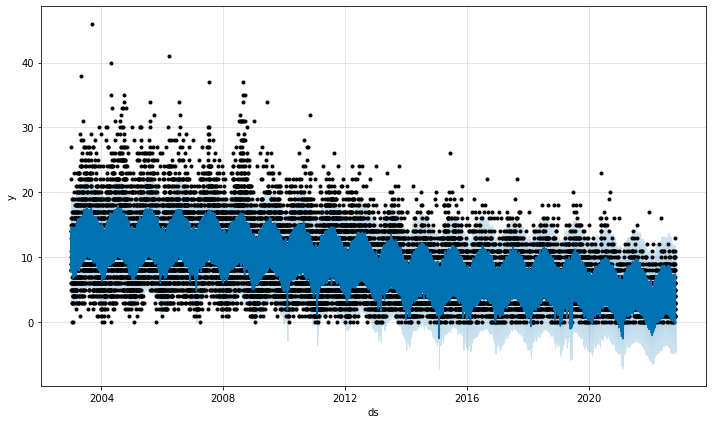

46


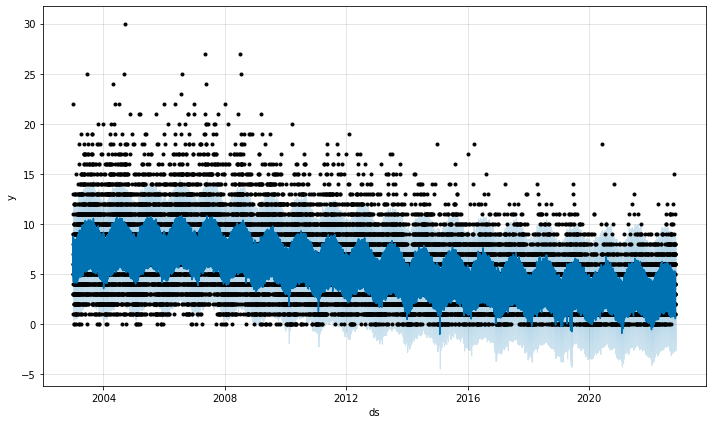

56


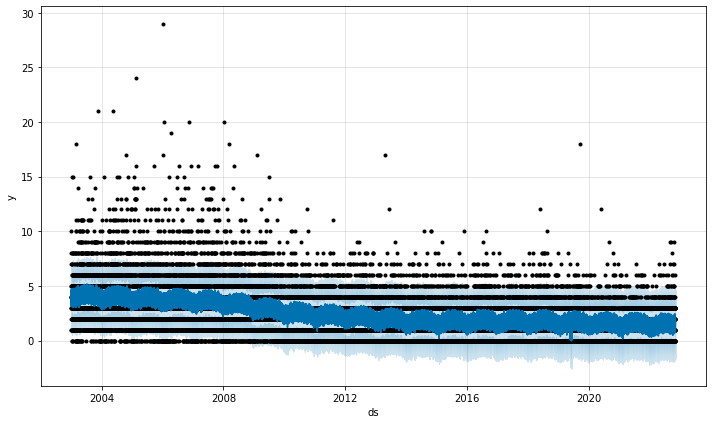

28


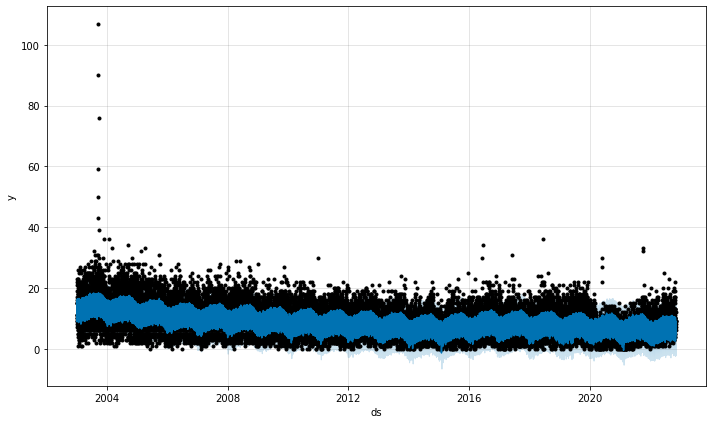

65


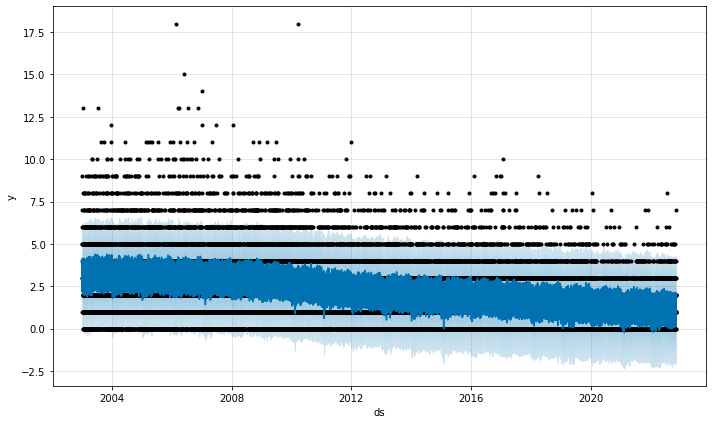

19


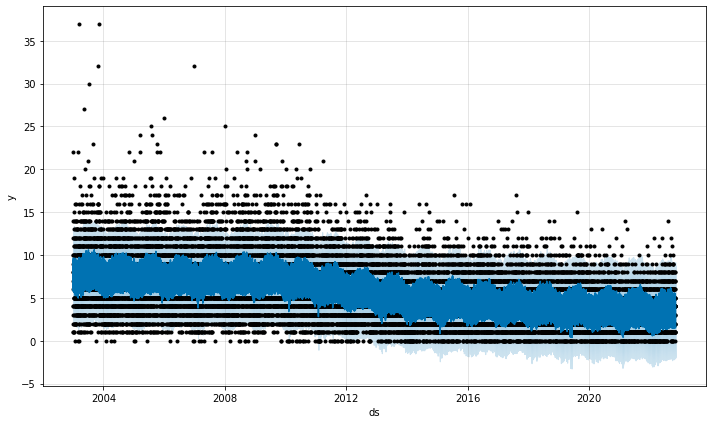

9


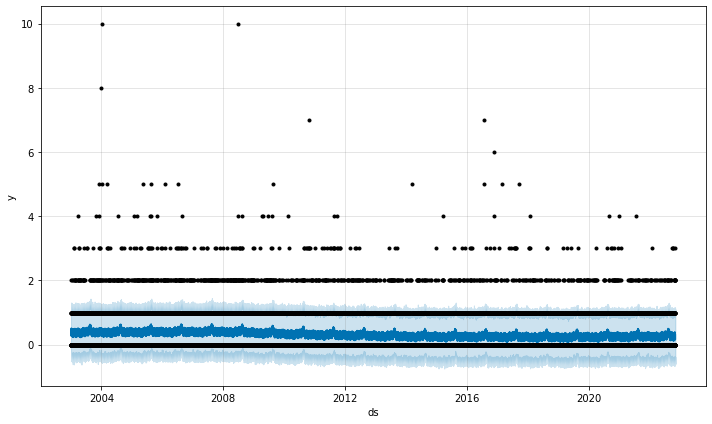

23


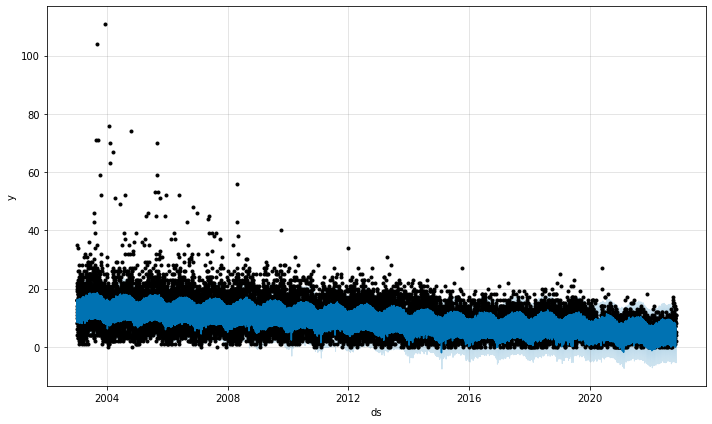

24


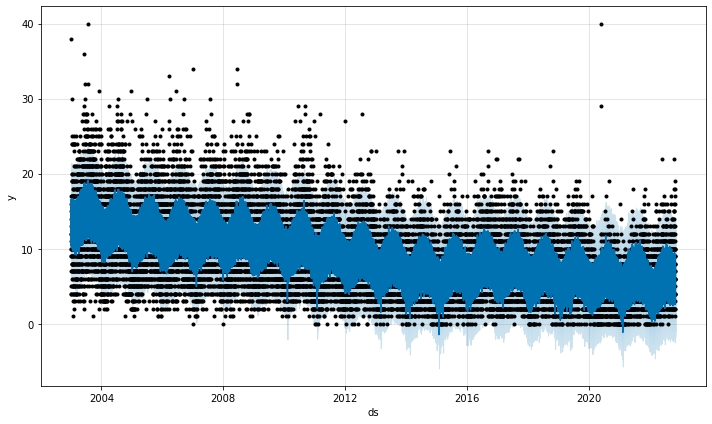

32


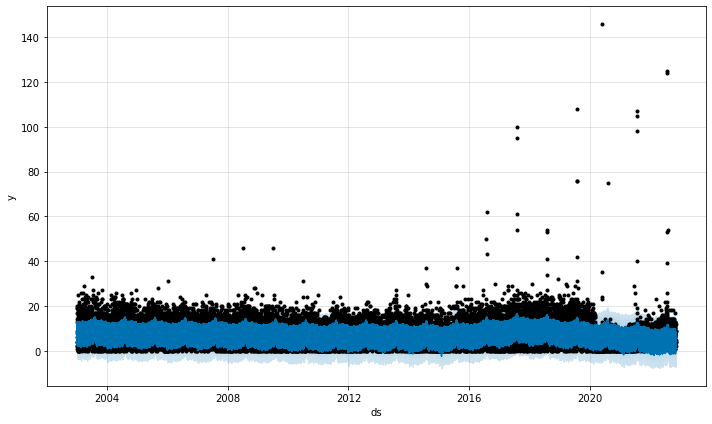

72


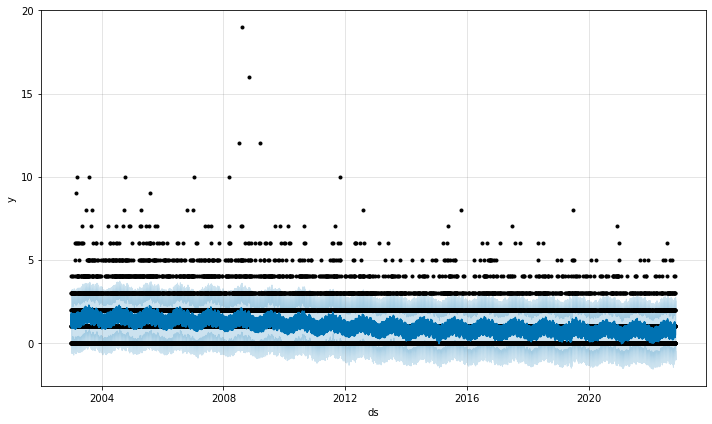

60


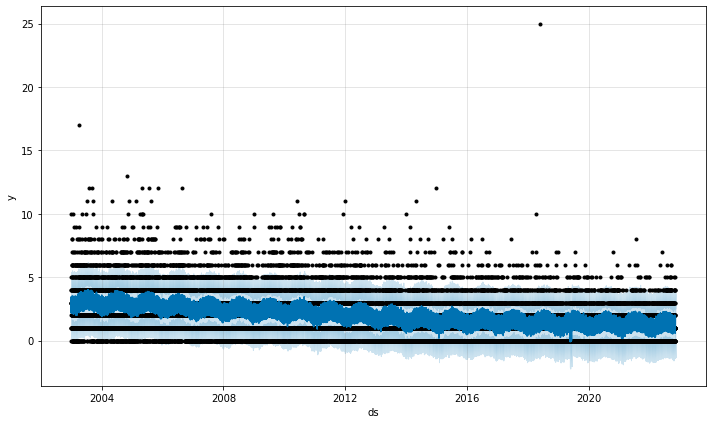

66


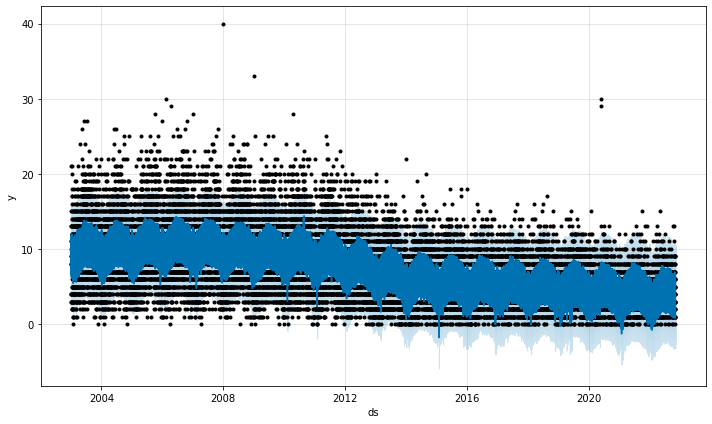

15


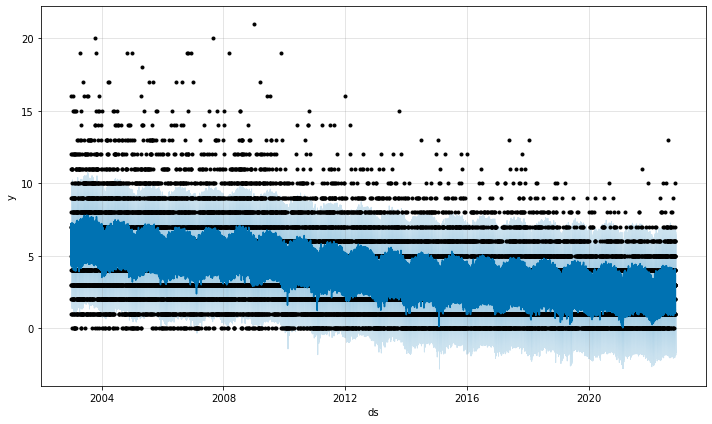

44


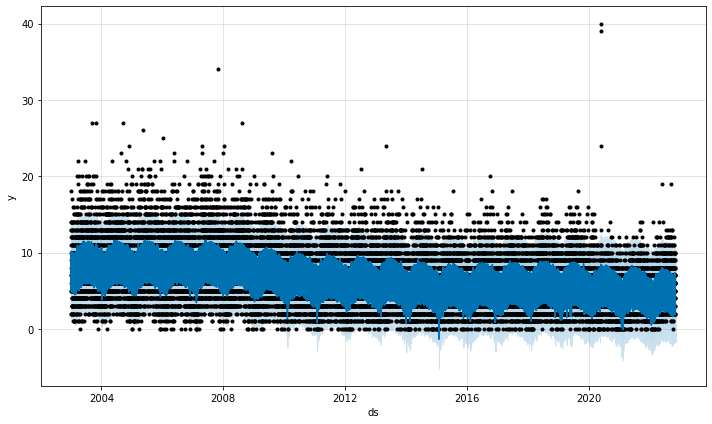

6


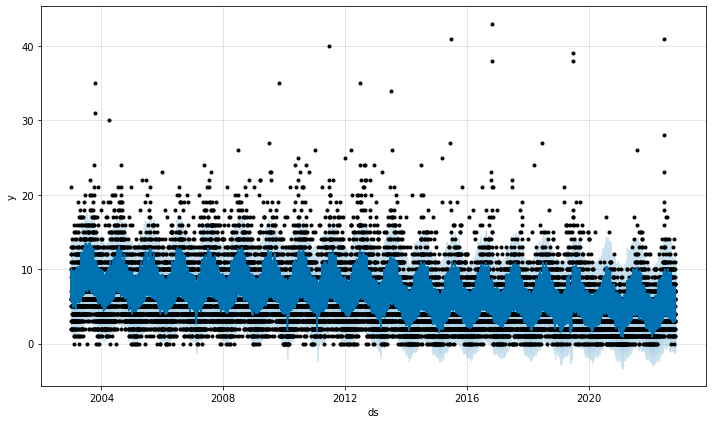

39


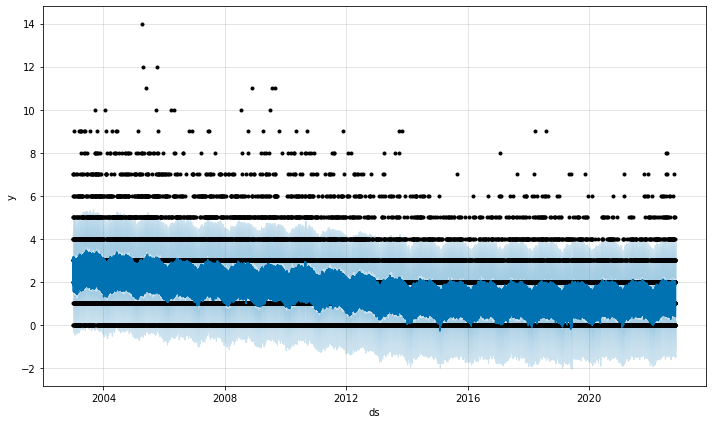

In [ ]:
def check_mod(ca, model, forecast):
  print(ca)
  fig = model.plot(forecast)
  plt.show()
df_results.apply(lambda x: check_mod(x['ca'], x['model'], x['forecast']), axis=1);

In [ ]:
df_results.drop(['model', 'forecast'], axis=1, inplace=True)

In [ ]:
# df_results.to_pickle('/content/drive/MyDrive/prophet_models/prophet_model_files.pkl')
df_results

ca t_res            scaler  \
0   62    8H  StandardScaler()   
1   16    8H  StandardScaler()   
2   55    8H  StandardScaler()   
3   47    8H  StandardScaler()   
4   14    8H  StandardScaler()   
..  ..   ...               ...   
72  66    8H  StandardScaler()   
73  15    8H  StandardScaler()   
74  44    8H  StandardScaler()   
75   6    8H  StandardScaler()   
76  39    8H  StandardScaler()   

                                           train_exog  
0                          ds  bulls  cubs  sox  b...  
1                          ds  bulls  cubs  sox  b...  
2                          ds  bulls  cubs  sox  b...  
3                          ds  bulls  cubs  sox  b...  
4                          ds  bulls  cubs  sox  b...  
..                                                ...  
72                         ds  bulls  cubs  sox  b...  
73                         ds  bulls  cubs  sox  b...  
74                         ds  bulls  cubs  sox  b...  
75                         ds  bulls  cubs  sox  b...  
76                         ds  bulls  cubs  sox  b...  

[77 rows x 4 columns]